## Milestone 2: Power Analysis
## Estée Lauder Power Analysis
#
## **Authors:** Selena Ho, Sahiti Srikakolapu, Rosina Zhou, Neveah Clark,
##              Angela Wang, Abubakar Diallo, Kaylee Scanlin

In [20]:
# POWER ANALYSIS MILESTONE #3
# Comparing Standard vs MLRATE Methods
# ====================================================================
# Requirements:
# - Statistical Power: 90%
# - Significance Level: 5%
# - MDE: 1% of baseline revenue
# ====================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ====================================================================
# DATA LOADING
# ====================================================================

df = pd.read_parquet("https://drive.google.com/uc?export=download&id=1W7KckqLdLLQCut0o1I-8mDYK60zSZY_J")

# Prepare target and features
y = df['revenue (t)']
X = df.drop(columns=['revenue (t)', 'customer_id', 'name'], axis=1)

print(f"Dataset loaded: {len(df):,} customers")
print(f"Features: {list(X.columns)}")
print(f"Mean revenue: ${y.mean():.2f}")
print(f"Revenue std: ${y.std(ddof=1):.2f}\n")

Dataset loaded: 20,000 customers
Features: ['aov (t-1)', 'days_since_last_purchase (t-1)', 'tenure_in_days(t-1)', 'loyalty_membership']
Mean revenue: $117.22
Revenue std: $23.99



In [21]:
# ====================================================================
# EXPERIMENT PARAMETERS
# ====================================================================

ALPHA = 0.05          # Significance level
POWER = 0.90          # Statistical power
MDE_PERCENT = 0.01    # 1% MDE

# Calculate MDE in revenue units
mu_baseline = y.mean()
Delta = MDE_PERCENT * mu_baseline

print("="*60)
print("EXPERIMENT PARAMETERS")
print("="*60)
print(f"Significance level (α): {ALPHA}")
print(f"Statistical power: {POWER}")
print(f"MDE: {MDE_PERCENT*100}% of baseline")
print(f"MDE in $ units: ${Delta:.2f}")
print(f"Baseline mean revenue: ${mu_baseline:.2f}\n")

EXPERIMENT PARAMETERS
Significance level (α): 0.05
Statistical power: 0.9
MDE: 1.0% of baseline
MDE in $ units: $1.17
Baseline mean revenue: $117.22



In [22]:
# ====================================================================
# METHOD 1: STANDARD T-TEST POWER ANALYSIS
# ====================================================================

print("="*60)
print("METHOD 1: STANDARD T-TEST POWER ANALYSIS")
print("="*60)

# Outcome variance
sY = y.std(ddof=1)

# Calculate effect size (Cohen's d)
cohens_d_standard = Delta / sY

# Calculate sample size using statsmodels
analysis = TTestIndPower()
n_per_arm_standard = analysis.solve_power(
    effect_size=cohens_d_standard,
    power=POWER,
    alpha=ALPHA,
    alternative="two-sided"
)

N_standard = 2 * n_per_arm_standard

print(f"\nOutcome SD (sY): ${sY:.2f}")
print(f"Cohen's d: {cohens_d_standard:.4f}")
print(f"\nRequired sample size:")
print(f"  Per arm: {int(np.ceil(n_per_arm_standard)):,}")
print(f"  Total: {int(np.ceil(N_standard)):,}")

METHOD 1: STANDARD T-TEST POWER ANALYSIS

Outcome SD (sY): $23.99
Cohen's d: 0.0489

Required sample size:
  Per arm: 8,802
  Total: 17,603


In [23]:
# ====================================================================
# METHOD 2: MLRATE (VARIANCE-REDUCED) POWER ANALYSIS
# ====================================================================

print("\n" + "="*60)
print("METHOD 2: MLRATE VARIANCE-REDUCED POWER ANALYSIS")
print("="*60)

# Step 1: Cross-fitted ML predictions using Random Forest
print("\nStep 1: Training ML model with cross-validation...")

kf = KFold(n_splits=2, random_state=42, shuffle=True)
G = np.zeros(len(y))

for train_idx, test_idx in kf.split(X.values, y.values):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train = y.values[train_idx]

    model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    G[test_idx] = model.predict(X_test)

# Step 2: Calculate R² and residuals
R2 = r2_score(y.values, G)
res_ml = y.values - G
s_e = res_ml.std(ddof=1)

print(f"Model R²: {R2:.3f} ({R2*100:.1f}%)")
print(f"Residual SD (s_e): ${s_e:.2f}")
print(f"Variance reduction: {(1 - s_e**2/sY**2)*100:.1f}%")

# Step 3: Calculate MLRATE sample size
cohens_d_mlrate = Delta / s_e

n_per_arm_mlrate = analysis.solve_power(
    effect_size=cohens_d_mlrate,
    power=POWER,
    alpha=ALPHA,
    alternative="two-sided"
)

N_mlrate = 2 * n_per_arm_mlrate

print(f"\nCohen's d (MLRATE): {cohens_d_mlrate:.4f}")
print(f"\nRequired sample size:")
print(f"  Per arm: {int(np.ceil(n_per_arm_mlrate)):,}")
print(f"  Total: {int(np.ceil(N_mlrate)):,}")


METHOD 2: MLRATE VARIANCE-REDUCED POWER ANALYSIS

Step 1: Training ML model with cross-validation...
Model R²: 0.683 (68.3%)
Residual SD (s_e): $13.50
Variance reduction: 68.3%

Cohen's d (MLRATE): 0.0868

Required sample size:
  Per arm: 2,789
  Total: 5,577



COMPARISON: STANDARD vs MLRATE

          Method  Per Arm  Total N  Cohen's d  Variance (SD²)
Standard t-test     8802    17603   0.048867      575.449374
         MLRATE     2789     5577   0.086828      182.269865

Sample size reduction: 68.3%
Efficiency gain: MLRATE requires only 31.7% of standard sample size


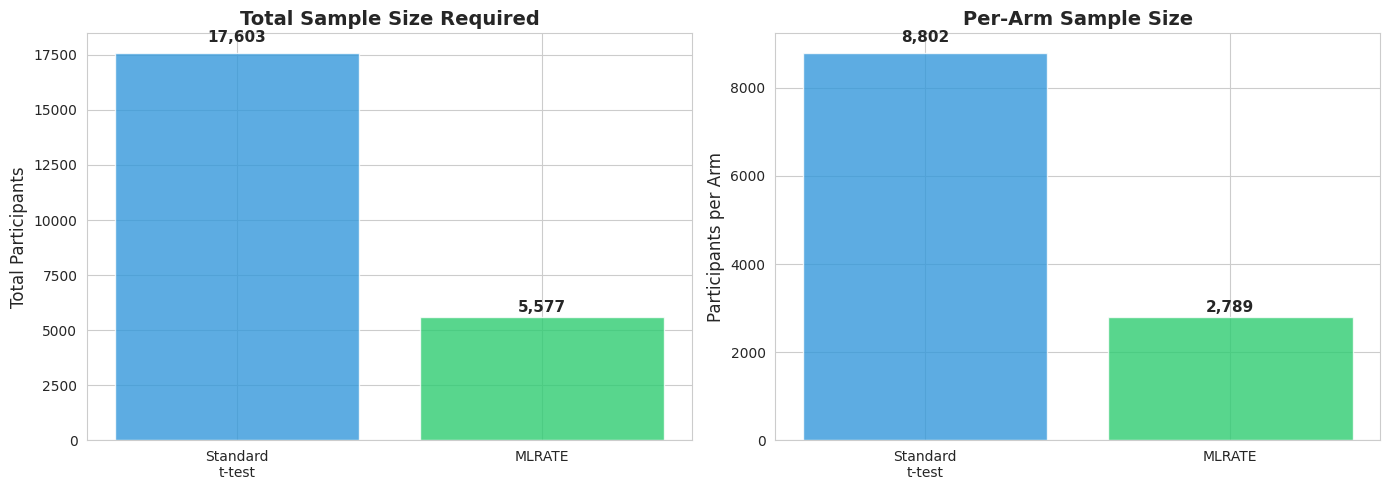

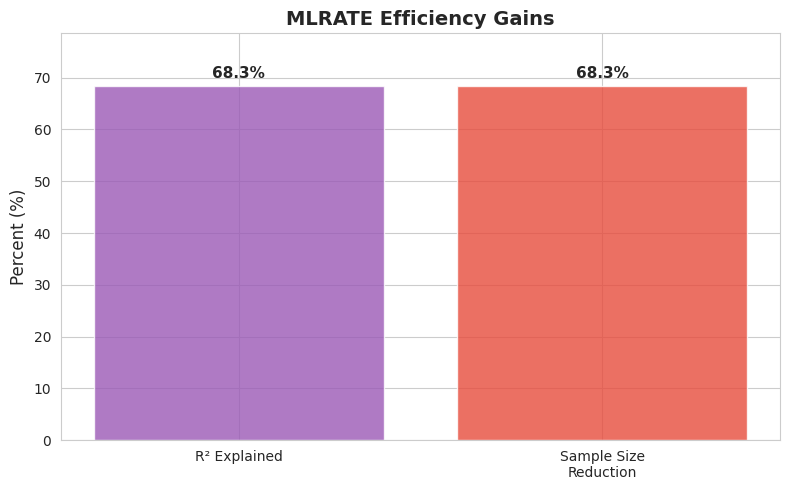

In [24]:
# ====================================================================
# COMPARISON: STANDARD vs MLRATE
# ====================================================================

print("\n" + "="*60)
print("COMPARISON: STANDARD vs MLRATE")
print("="*60)

reduction_pct = 100 * (1 - N_mlrate / N_standard)

comparison_data = {
    'Method': ['Standard t-test', 'MLRATE'],
    'Per Arm': [int(np.ceil(n_per_arm_standard)), int(np.ceil(n_per_arm_mlrate))],
    'Total N': [int(np.ceil(N_standard)), int(np.ceil(N_mlrate))],
    'Cohen\'s d': [cohens_d_standard, cohens_d_mlrate],
    'Variance (SD²)': [sY**2, s_e**2]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

print(f"\nSample size reduction: {reduction_pct:.1f}%")
print(f"Efficiency gain: MLRATE requires only {(N_mlrate/N_standard)*100:.1f}% of standard sample size")

# Visualization: Sample Size Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = ['Standard\nt-test', 'MLRATE']
total_vals = [N_standard, N_mlrate]
per_arm_vals = [n_per_arm_standard, n_per_arm_mlrate]
colors = ['#3498db', '#2ecc71']

# Total N comparison
axes[0].bar(methods, total_vals, color=colors, alpha=0.8)
axes[0].set_title('Total Sample Size Required', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Total Participants', fontsize=12)
for i, v in enumerate(total_vals):
    axes[0].text(i, v*1.02, f'{int(np.ceil(v)):,}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Per arm comparison
axes[1].bar(methods, per_arm_vals, color=colors, alpha=0.8)
axes[1].set_title('Per-Arm Sample Size', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Participants per Arm', fontsize=12)
for i, v in enumerate(per_arm_vals):
    axes[1].text(i, v*1.02, f'{int(np.ceil(v)):,}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Visualization: Variance Reduction
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(['R² Explained', 'Sample Size\nReduction'],
              [R2*100, reduction_pct],
              color=['#9b59b6', '#e74c3c'], alpha=0.8)
ax.set_ylabel('Percent (%)', fontsize=12)
ax.set_title('MLRATE Efficiency Gains', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(R2*100, reduction_pct)*1.15)

for bar, val in zip(bars, [R2*100, reduction_pct]):
    ax.text(bar.get_x() + bar.get_width()/2, val + 1,
           f'{val:.1f}%', ha='center', va='bottom',
           fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


RESIDUAL DISTRIBUTION ANALYSIS
Residual std: 13.453288377572761
Effect size: -0.013399108940816529
Required sample size (solve_power): 87435.85081933203


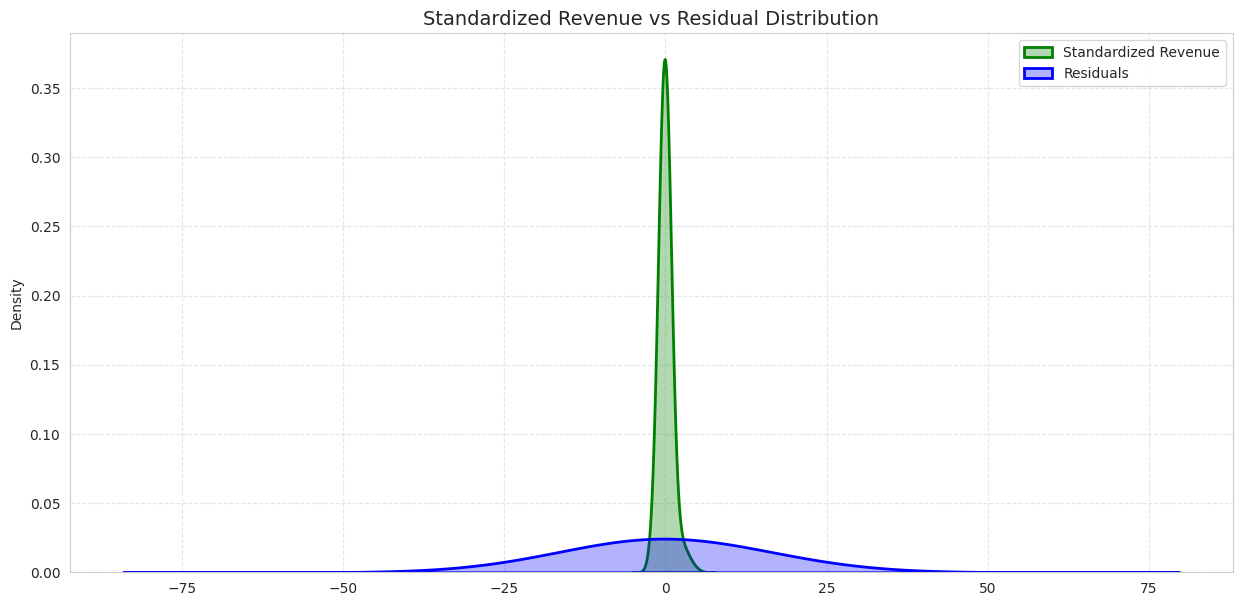

In [25]:
# ====================================================================
# RESIDUAL DISTRIBUTION PLOT
# ====================================================================

print("\n" + "="*60)
print("RESIDUAL DISTRIBUTION ANALYSIS")
print("="*60)

X_const = sm.add_constant(G)
OLS_model = sm.OLS(y, X_const) # redo cell and replace x with G
results = OLS_model.fit(cov_type="HC0")
residuals = results.resid

resid_std = residuals.std(ddof=1)

diff = G[:len(G)//2].mean() - G[len(G)//2:].mean()
effect_size = diff / resid_std

analysis = TTestIndPower()
sample_size = analysis.solve_power(
    effect_size=effect_size,
    power=0.8,       # desired power
    alpha=0.05,
    alternative="two-sided"
)

print("Residual std:", resid_std)
print("Effect size:", effect_size)
print("Required sample size (solve_power):", sample_size)

# Define X and y for the OLS model
# (Assuming X and y are defined in a previous cell and you want to reuse them)
# If not, you would need to redefine them here or in an earlier cell.
# Based on the notebook state, X and y are defined in cell DvDmrFzx4anD
df = pd.read_parquet("https://drive.google.com/uc?export=download&id=1W7KckqLdLLQCut0o1I-8mDYK60zSZY_J")
y = df['revenue (t)']
X = df.drop(columns = ['revenue (t)', 'customer_id','name'],axis=1)

scaler = StandardScaler()
y_std = scaler.fit_transform(y.values.reshape(-1,1)).flatten()

# Run OLS model to get residuals
OLS_model = sm.OLS(y, X_const)
results = OLS_model.fit(cov_type="HC0") # Define results

# Residuals from OLS/ML
residuals = results.resid

plt.figure(figsize=(15,7))

sns.kdeplot(y_std, color="green", lw=2, label="Standardized Revenue", fill=True, alpha=0.3, bw_adjust=5)
sns.kdeplot(residuals, color="blue", lw=2, label="Residuals", fill=True, alpha=0.3, bw_adjust=5)

plt.grid(True, linestyle='--', alpha=0.5)

plt.legend()
plt.title("Standardized Revenue vs Residual Distribution", fontsize=14)
plt.show()

In [26]:
# ====================================================================
# SUMMARY & RECOMMENDATIONS
# ====================================================================

print("\n" + "="*60)
print("SUMMARY & RECOMMENDATIONS")
print("="*60)

print(f"""
KEY FINDINGS:
1. Standard t-test requires {int(np.ceil(N_standard)):,} total participants
2. MLRATE reduces this to {int(np.ceil(N_mlrate)):,} total participants
3. Sample size reduction: {reduction_pct:.1f}%
4. Model explains {R2*100:.1f}% of revenue variance

INTERPRETATION:
- By leveraging pre-experiment covariates (AOV, recency, tenure, loyalty),
  we can reduce the required sample size by approximately {reduction_pct:.0f}%
- The residual variance (${s_e:.2f}) is much smaller than raw variance (${sY:.2f})
- This efficiency gain translates to faster experiments and lower costs

RECOMMENDATION:
Use MLRATE method with covariate adjustment for the upcoming experiment.
Required sample size: {int(np.ceil(N_mlrate)):,} customers
({int(np.ceil(n_per_arm_mlrate)):,} per treatment arm)
""")


SUMMARY & RECOMMENDATIONS

KEY FINDINGS:
1. Standard t-test requires 17,603 total participants
2. MLRATE reduces this to 5,577 total participants
3. Sample size reduction: 68.3%
4. Model explains 68.3% of revenue variance

INTERPRETATION:
- By leveraging pre-experiment covariates (AOV, recency, tenure, loyalty),
  we can reduce the required sample size by approximately 68%
- The residual variance ($13.50) is much smaller than raw variance ($23.99)
- This efficiency gain translates to faster experiments and lower costs

RECOMMENDATION:
Use MLRATE method with covariate adjustment for the upcoming experiment.
Required sample size: 5,577 customers
(2,789 per treatment arm)

